In [1]:
#Ideas
#Track down the incorrect predictions and see where they are in the distribition of the rest of the data
#Softmax function at the output layer?
#Make sure the weight initialization is random each time
#Can you somehow control the weight initialization to make sure its in a small range?

In [2]:
#HYPERPARAMETERS:
#-Activation function
#-Weight initialisation
#-Loss function
#-Training Algorithms
#-Training Algorithm parameters
#-Learning rate

In [3]:
#Previous Configurations

#Model 1
# model = myNN(12,3,{1:20,2:20,3:15,4:10,5:5})

# learning_rate = 0.01
# criterion = nn.MSELoss()
# # criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
import random
import copy
import seaborn as sns

In [5]:
with open('almonds_prep.pickle','rb') as file:
    All = pickle.load(file)

In [6]:
def myMSE(pred,true):
    return ((pred-true)**2).mean()

def convert(yout):
    y_out = copy.deepcopy(yout)
    for h in range(y_out.shape[0]):
        y_out[h][y_out[h] == y_out[h].max()] = 1
        y_out[h][y_out[h] != y_out[h].max()] = 0
    return y_out

def data_shuffler(X,Y,Y_binary):
    idxs = np.arange(0,len(X))
    random.shuffle(idxs)
    
    X_new = X[idxs]
    Y_new = Y[idxs]
    Y_binary_new = Y_binary[idxs]
    return X_new,Y_new,Y_binary_new

def batch_maker(X,Y,Y_binary,num_batches): #X,Y-> shuffled input and outputs
    tot = len(X)
    div = int(np.ceil(tot/num_batches))
#     print(div)
    
    if num_batches == 1:
        return X,Y,Y_binary
    cnt1 = 0
    cnt2 = div
    Xbatch = []
    Ybatch = []
    Y_binary_batch = []
    for i in range(num_batches-1):
        
        Xbatch.append(X[cnt1:cnt2,:])
        Ybatch.append(Y[cnt1:cnt2])
        Y_binary_batch.append(Y_binary[cnt1:cnt2,:])

        cnt1 = cnt2
        cnt2 = cnt1 + div
        
    Xbatch.append(X[cnt1:,:])
    Ybatch.append(Y[cnt1:])
    Y_binary_batch.append(Y_binary[cnt1:,:])

    return Xbatch,Ybatch,Y_binary_batch

def kfold_maker(X,Y,k): #X,Y-> unshuffled input and outputs
    tot = len(X)
    div = int(np.ceil(tot/k))
#     print(div)
    
    if k == 1:
        return X,Y
    cnt1 = 0
    cnt2 = div
    Xfolds = []
    Yfolds = []
    for i in range(k-1):
        
        Xfolds.append(X[cnt1:cnt2,:])
        Yfolds.append(Y[cnt1:cnt2,:])
        
        cnt1 = cnt2
        cnt2 = cnt1 + div
        
    Xfolds.append(X[cnt1:,:])
    Yfolds.append(Y[cnt1:,:])

    return Xfolds,Yfolds

def accuracy_calc(ytrain_pred, ytrain_target, ytest_pred, ytest_target):
    
    cnt_train = 0

    for h in range(len(ytrain_pred)):
        if sum(ytrain_pred[h,:] == ytrain_target[h,:]) < ytrain_target.shape[1]:
            cnt_train = cnt_train + 1
    incorr_pred_train = cnt_train

    cnt_test = 0
    for j in range(len(ytest_pred)):
        if sum(ytest_pred[j,:] == ytest_target[j,:]) < ytest_target.shape[1]:
            cnt_test = cnt_test + 1
    incorr_pred_test = cnt_test
    return incorr_pred_train, incorr_pred_test

In [7]:
class myNN(nn.Module):
    
    def __init__(self,n_input_features,n_output_features,n_layers_neurons):
        """
        n_input_features = Number of input features
        n_output_features = Number of output features
        n_layers_neurons = Dictionary of HIDDEN layer number and number of neurons in layer
           e.g.  3 hidden layers with 4, 2, and 7 neurons, respectively==> {1:4, 2: 2, 3: 7}
        
        """
        
        super().__init__()
        self.n_hidden_layers = len(list(n_layers_neurons)) #number of hidden layers
        #Creating all the layers
        
        self.layers = nn.ModuleList([nn.Linear(in_features = n_input_features, out_features = n_layers_neurons[1])])#First hidden layer
        
        for n in range(len(n_layers_neurons)-1):
            
            #All hidden layers
            self.layers.append(nn.Linear(in_features = n_layers_neurons[n+1], out_features = n_layers_neurons[n+2]))
            
        self.layers.append(nn.Linear(in_features = n_layers_neurons[list(n_layers_neurons)[-1]], out_features = n_output_features)) #Output layer

        
    def forward(self,x):
        
        #Hidden layers
        ys = []
        ys.append(nn.Tanh()(self.layers[0](x)))
#         print('First layer:',ys)
        for i in range(self.n_hidden_layers - 1):
#             print(i)
            net = self.layers[i+1](ys[i])
            ys.append(nn.Tanh()(net)) #Hidden layers
        
        net_output = self.layers[-1](ys[-1])
        output = nn. Softmax(dim=1)(net_output)
        return output,net_output

In [8]:
Xnum = np.vstack((All[0],All[1],All[2]))
print(Xnum.shape)

(2803, 13)


In [9]:
#Classes: 'MAMRA = [1,0,0]', 'SANORA = [0,1,0]', 'REGULAR' = [0,0,1]
Ynum = []
n_classes = 3
for n in range(len(Xnum)):
    if Xnum[n,-1] == "MAMRA":
        Ynum.append([1,0,0,0])
        
    elif Xnum[n,-1] == "SANORA":
        Ynum.append([0,1,0,1])
        
    elif Xnum[n,-1] == "REGULAR":
        Ynum.append([0,0,1,2])
        
    else:
        print(f"Error row index: {n}")

Xnum = Xnum[:,:-1]
Ynum = np.array(Ynum)
print(f"Input shape: {Xnum.shape}")
print(f"Output shape: {Ynum.shape}")

Input shape: (2803, 12)
Output shape: (2803, 4)


In [10]:
Xnum_train,_,Ynum_train,_ = train_test_split(Xnum,Ynum,test_size = 0.3)
print("X train: ", Xnum_train.shape)
print("Y train: ", Ynum_train.shape)

X_trainb = torch.tensor(Xnum_train.astype(np.float32))
Y_trainb = torch.tensor(Ynum_train,dtype=torch.long)

X train:  (1962, 12)
Y train:  (1962, 4)


In [11]:
criterion = nn.CrossEntropyLoss(reduction = 'none')
n_classes = 3
k = 5 #Number of folds
Xfolds,Yfolds = kfold_maker(X_trainb,Y_trainb,k = k)
print("Number of folds:",len(Xfolds))
print("Percentage of each fold:", len(Xfolds[0])/len(X_trainb)*100)

Number of folds: 5
Percentage of each fold: 20.03058103975535


In [12]:
def CV_model(learning_rate,momentum):
    losses_train_run = [] #Training loss for entire training set of each kfold run
    losses_test_run = []
    num_epochs_run = []

    losses_train_kfold = []
    losses_test_kfold = []

    accuracy_train = []
    accuracy_test = []

    for i in range(k): #for each k-fold run...

        model = myNN(12,3,{1:20,2:20,3:15,4:10,5:5})

        optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate,momentum = momentum)

        print(f"K = {i + 1}")
        losses_train = [] #Losses for each epoch
        losses_test = []
        
        #Splitting the training and testing folds
        Xfolds_mod = copy.deepcopy(Xfolds)
        Yfolds_mod = copy.deepcopy(Yfolds)

        XTestFold = Xfolds_mod.pop(i) #The fold that will be used for testing
        YTestFold = Yfolds_mod.pop(i)

        XTrainFold = Xfolds_mod #The rest of the folds used for training
        YTrainFold = Yfolds_mod

        #Combining the training folds
        XTrainFold = torch.concatenate(XTrainFold,axis = 0)
        YTrainFold = torch.concatenate(YTrainFold,axis = 0)
        print("Validation training data shape X:", XTrainFold.shape)
        print("Validation training data shape Y:", YTrainFold.shape)

        #Standardising the whole validation data on the training validation data
        sc = StandardScaler()
        XTrainFold = torch.tensor(sc.fit_transform(XTrainFold),dtype = torch.float32)
        XTestFold = torch.tensor(sc.transform(XTestFold),dtype = torch.float32)

        #Splitting the target data into binary and index
        YTrainFold_bin = YTrainFold[:,:-1]
        YTrainFold_idx = YTrainFold[:,-1]

        YTestFold_bin = YTestFold[:,:-1]
        YTestFold_idx = YTestFold[:,-1]

        num_epochs = 0
        tol = 8e-3 #tells us when to stop training
        error = 100
        while (error > tol) and num_epochs < 500:

            num_epochs += 1
            #Shuffling the training validation data
            X_train,Y_train,Y_binary_train = data_shuffler(XTrainFold,YTrainFold_idx,YTrainFold_bin)

            #Divide the training data into batches
            num_batches = 1
            Xbatches, Ybatches,YBinaryBatches = batch_maker(X_train,Y_train,Y_binary_train,num_batches)

        #=======================TRAINING================================
            for iteration in range(num_batches): #for each batch...
                
                if num_batches == 1:
                    X_train_batch = Xbatches
                    Y_train_batch = Ybatches
                    Y_train_binary_batch = YBinaryBatches
                    
                else:     

                    X_train_batch = Xbatches[iteration]
                    Y_train_batch = Ybatches[iteration]
                    Y_train_binary_batch = YBinaryBatches[iteration]

                #Forward pass
                ypred_train,output_net = model(X_train_batch) #net_ouput is the output before the activation function of the output layer. This goes into the loss function.

                #Compute loss
                loss_train = criterion(output_net,Y_train_batch).sum()/(n_classes*len(Y_train_batch))

                #Backward pass
                loss_train.backward()

                #Update weights
                optimizer.step()
                optimizer.zero_grad()

            #This happens when we've run through all batches
            with torch.no_grad():

                ypred_train_epoch,output_net_train_epoch = model(X_train)
                ypred_test_epoch,output_net_test_epoch = model(XTestFold)

                loss_train_epoch = criterion(output_net_train_epoch,Y_train).sum()/(n_classes*len(Y_train))
                losses_train.append(loss_train_epoch)

                loss_test_epoch = criterion(output_net_test_epoch,YTestFold_idx).sum()/(n_classes*len(YTestFold_idx))
                losses_test.append(loss_test_epoch)

                error = ((ypred_train_epoch - Y_binary_train)**2).mean()
    #=======================DONE TRAINING================================
        losses_train_kfold.append(losses_train)
        losses_test_kfold.append(losses_test)

        if num_epochs == 500:
            print("Training Stopped due to maximum number of iterations reached")

        num_epochs_run.append(num_epochs)

        #TESTING
        with torch.no_grad():

            #Final training and testing for a kfold run
            ypred_train_fold,output_net_train_fold = model(XTrainFold)
            ypred_test_fold,output_net_test_fold = model(XTestFold)

            loss_train_fold = criterion(output_net_train_fold,YTrainFold_idx).sum()/(n_classes*len(YTrainFold_idx))
            losses_train_run.append(loss_train_fold)

            loss_test_fold = criterion(output_net_test_fold,YTestFold_idx).sum()/(n_classes*len(YTestFold_idx))
            losses_test_run.append(loss_test_fold)
            print(f"Training loss: {loss_train_fold}")
            print(f"Testing loss: {loss_test_fold}")

            #Accuracy Calculation
            Ypred_train_fold = convert(ypred_train_fold)
            Ypred_test_fold = convert(ypred_test_fold)

            cnt_train,cnt_test = accuracy_calc(Ypred_train_fold, YTrainFold_bin, Ypred_test_fold, YTestFold_bin)
            accuracy_train.append(100-(cnt_train/len(Ypred_train_fold)*100))
            accuracy_test.append(100-(cnt_test/len(Ypred_test_fold)*100))
            print("Accuracy Train:", 100-(cnt_train/len(Ypred_train_fold)*100))
            print("Accuracy Test:", 100-(cnt_test/len(Ypred_test_fold)*100))

    losses_train_run = torch.tensor(losses_train_run)
    losses_test_run = torch.tensor(losses_test_run)

    accuracy_train = torch.tensor(accuracy_train)
    accuracy_test = torch.tensor(accuracy_test)

    avg_train_loss = losses_train_run.mean()
    avg_test_loss = losses_test_run.mean()

    avg_train_acc = accuracy_train.mean()
    avg_test_acc = accuracy_test.mean()

    std_loss_train = torch.sqrt(torch.var(losses_train_run))
    std_loss_test = torch.sqrt(torch.var(losses_test_run))
    
    std_acc_train = torch.sqrt(torch.var(accuracy_train))
    std_acc_test = torch.sqrt(torch.var(accuracy_test))
    return {"LossTrain":losses_train_run,
            "LossTest":losses_test_run,
            "AccTrain":accuracy_train,
            "AccTest":accuracy_test,
            "AvgTrainLoss":avg_train_loss,
            "AvgTestLoss":avg_test_loss,
            "AvgTrainAcc":avg_train_acc,
            "AvgTestAcc":avg_test_acc,
            "StdTrainLoss":std_loss_train,
           "StdTestLoss":std_loss_test,
           "AllLossTrain":losses_train_kfold,
           "AllLossTest": losses_test_kfold,
           "TotNumEpochs":num_epochs_run,
           "StdAccTrain":std_acc_train,
           "StdAccTest":std_acc_test}

In [13]:
# test = CV_model(learning_rate = 1,momentum = 1)

In [14]:
# fig0, ax0 = plt.subplots(k,1,figsize = (10,8),layout = 'constrained')

# for i in range(k):
#     ax0[i].set_yscale('log')
#     ax0[i].plot(test["AllLossTrain"][i],color='b',marker = 'o')
#     ax0[i].plot(test["AllLossTest"][i],color='r',marker = 'o')
#     ax0[i].set_xlim()

In [15]:
# learning_rate_values = torch.arange(1.6,2.1,0.05)
# momentum_values = torch.arange(0.3,0.4,0.01)


learning_rate_values = torch.arange(0.9,2.1,0.1)
momentum_values = torch.arange(0.1,0.8,0.1)

print("Learning rate values: \n",learning_rate_values)
print("Momentum_values: \n", momentum_values )

LR, M = torch.meshgrid(learning_rate_values,momentum_values)
total = len(learning_rate_values)*len(momentum_values)

Learning rate values: 
 tensor([0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000])
Momentum_values: 
 tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000])


D:\Anaconda_installation\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [46]:
results[2]["TotNumEpochs"]

[369, 417, 500, 388, 468]

In [16]:
row = 0
colm = 0
results = []
for t in range(total):
    if colm == LR.shape[1]:
        colm = 0
        row += 1
    learning_rate = LR[row,colm]
    momentum = M[row,colm]
    colm += 1
    
    ans = CV_model(learning_rate = learning_rate,momentum = momentum)
    results.append(ans)
    
    print(f"=======Done {t + 1}========")

K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 0.041345059871673584
Testing loss: 0.05151011422276497
Accuracy Train: 95.47482472912684
Accuracy Test: 93.38422391857506
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.02405182272195816
Testing loss: 0.04083957150578499
Accuracy Train: 99.4263862332696
Accuracy Test: 97.96437659033079
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 0.04085610806941986
Testing loss: 0.042785197496414185
Accuracy Train: 95.53855959209687
Accuracy Test: 96.94656488549619
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([156

Training loss: 0.021947665140032768
Testing loss: 0.02426084503531456
Accuracy Train: 98.98024219247928
Accuracy Test: 98.9821882951654
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.021803265437483788
Testing loss: 0.029552096500992775
Accuracy Train: 99.23518164435947
Accuracy Test: 98.72773536895674
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.023378213867545128
Testing loss: 0.04356193542480469
Accuracy Train: 99.10771191841937
Accuracy Test: 97.45547073791349
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.01752929389476776
Testing loss: 0.02158476784825325
Accuracy Train: 98.53409815168898
Accuracy Test: 98.21882951653944
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y:

Training loss: 0.021557027474045753
Testing loss: 0.024622326716780663
Accuracy Train: 98.59783301465902
Accuracy Test: 98.47328244274809
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.023427538573741913
Testing loss: 0.03648098558187485
Accuracy Train: 99.04397705544933
Accuracy Test: 97.96437659033079
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.017535120248794556
Testing loss: 0.034617163240909576
Accuracy Train: 99.29891650732951
Accuracy Test: 97.45547073791349
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.02094661444425583
Testing loss: 0.022273831069469452
Accuracy Train: 99.23518164435947
Accuracy Test: 98.9821882951654
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape 

Training loss: 0.02212284691631794
Testing loss: 0.03229580074548721
Accuracy Train: 99.10771191841937
Accuracy Test: 98.21882951653944
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.018202753737568855
Testing loss: 0.03222700208425522
Accuracy Train: 98.98024219247928
Accuracy Test: 97.70992366412214
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.020834896713495255
Testing loss: 0.02061103656888008
Accuracy Train: 99.29891650732951
Accuracy Test: 98.72773536895674
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: torch.Size([1572, 4])
Training loss: 0.022478608414530754
Testing loss: 0.023920444771647453
Accuracy Train: 99.04580152671755
Accuracy Test: 99.23076923076923
=======Done 19========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validatio

Training loss: 0.020626125857234
Testing loss: 0.038773465901613235
Accuracy Train: 98.66156787762907
Accuracy Test: 97.45547073791349
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.013439470902085304
Testing loss: 0.02881304919719696
Accuracy Train: 99.04397705544933
Accuracy Test: 96.94656488549619
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.021630316972732544
Testing loss: 0.025373589247465134
Accuracy Train: 99.17144678138942
Accuracy Test: 98.47328244274809
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: torch.Size([1572, 4])
Training loss: 0.020268982276320457
Testing loss: 0.023648321628570557
Accuracy Train: 99.30025445292621
Accuracy Test: 99.74358974358974
=======Done 25========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validatio

Training Stopped due to maximum number of iterations reached
Training loss: 0.032459162175655365
Testing loss: 0.050091344863176346
Accuracy Train: 96.74952198852772
Accuracy Test: 96.18320610687023
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.02201317623257637
Testing loss: 0.02248782478272915
Accuracy Train: 99.10771191841937
Accuracy Test: 98.9821882951654
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: torch.Size([1572, 4])
Training loss: 0.02211255021393299
Testing loss: 0.020785877481102943
Accuracy Train: 99.10941475826972
Accuracy Test: 99.48717948717949
=======Done 31========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.023148585110902786
Testing loss: 0.02912328578531742
Accuracy Train: 99.23518164435947
Accuracy Test: 98.72773536895674
K = 2
Valida

Accuracy Train: 99.23518164435947
Accuracy Test: 98.47328244274809
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 0.027301756665110588
Testing loss: 0.02963058091700077
Accuracy Train: 99.23518164435947
Accuracy Test: 99.4910941475827
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: torch.Size([1572, 4])
Training loss: 0.02032330445945263
Testing loss: 0.020950092002749443
Accuracy Train: 99.36386768447836
Accuracy Test: 99.48717948717949
=======Done 37========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.021926235407590866
Testing loss: 0.027321651577949524
Accuracy Train: 99.36265137029956
Accuracy Test: 98.72773536895674
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation trainin

Accuracy Train: 97.25940089228808
Accuracy Test: 96.43765903307889
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 0.041495490819215775
Testing loss: 0.051127612590789795
Accuracy Train: 95.15615041427661
Accuracy Test: 92.87531806615776
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: torch.Size([1572, 4])
Training loss: 0.02078898623585701
Testing loss: 0.02101035788655281
Accuracy Train: 99.30025445292621
Accuracy Test: 99.48717948717949
=======Done 43========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.02142423205077648
Testing loss: 0.027896367013454437
Accuracy Train: 99.10771191841937
Accuracy Test: 98.72773536895674
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation trainin

Training Stopped due to maximum number of iterations reached
Training loss: 0.09631688892841339
Testing loss: 0.11312058568000793
Accuracy Train: 90.69471000637348
Accuracy Test: 90.07633587786259
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.020930124446749687
Testing loss: 0.020692501217126846
Accuracy Train: 99.4263862332696
Accuracy Test: 99.74554707379134
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: torch.Size([1572, 4])
Training loss: 0.020033754408359528
Testing loss: 0.01851922646164894
Accuracy Train: 99.17302798982189
Accuracy Test: 98.97435897435898
=======Done 49========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 0.03837291896343231
Testing loss: 0.05024617537856102
Accuracy Train: 96.

Training loss: 0.02087356708943844
Testing loss: 0.030101262032985687
Accuracy Train: 98.66156787762907
Accuracy Test: 97.96437659033079
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.016542892903089523
Testing loss: 0.03316997364163399
Accuracy Train: 99.17144678138942
Accuracy Test: 97.45547073791349
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.019565869122743607
Testing loss: 0.022969918325543404
Accuracy Train: 98.98024219247928
Accuracy Test: 99.4910941475827
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: torch.Size([1572, 4])
Training loss: 0.019759759306907654
Testing loss: 0.021115373820066452
Accuracy Train: 99.23664122137404
Accuracy Test: 99.23076923076923
=======Done 55========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validati

Training Stopped due to maximum number of iterations reached
Training loss: 0.1004430279135704
Testing loss: 0.12126386165618896
Accuracy Train: 89.73868706182282
Accuracy Test: 87.27735368956743
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.021892085671424866
Testing loss: 0.028258027508854866
Accuracy Train: 99.74506054811982
Accuracy Test: 98.21882951653944
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.021676791831851006
Testing loss: 0.02240535244345665
Accuracy Train: 99.36265137029956
Accuracy Test: 99.74554707379134
K = 5
Validation training data shape X: torch.Size([1572, 12])
Validation training data shape Y: torch.Size([1572, 4])
Training loss: 0.02078975737094879
Testing loss: 0.02164875902235508
Accuracy Train: 99.10941475826972
Accuracy Test: 99.23076923076923
=======Done 61========
K = 1
Validat

Training loss: 0.018649650737643242
Testing loss: 0.025466235354542732
Accuracy Train: 98.34289356277884
Accuracy Test: 96.94656488549619
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.019769582897424698
Testing loss: 0.03329218551516533
Accuracy Train: 99.61759082217974
Accuracy Test: 98.47328244274809
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 0.07026294618844986
Testing loss: 0.08539766073226929
Accuracy Train: 88.97386870618229
Accuracy Test: 88.54961832061069
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.022367067635059357
Testing loss: 0.018714848905801773
Accuracy Train: 99.10771191841937
Accuracy Test: 99.4910941475827
K = 5
Validation training data sha

Training loss: 0.019021326676011086
Testing loss: 0.022856835275888443
Accuracy Train: 99.23664122137404
Accuracy Test: 98.97435897435898
=======Done 72========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.02076776698231697
Testing loss: 0.026078222319483757
Accuracy Train: 99.10771191841937
Accuracy Test: 98.21882951653944
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 0.024841776117682457
Testing loss: 0.03460913524031639
Accuracy Train: 99.4263862332696
Accuracy Test: 97.96437659033079
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 0.14779141545295715
Testing loss: 0.13509272038936615
Accuracy Train: 81

Training Stopped due to maximum number of iterations reached
Training loss: 0.02791444957256317
Testing loss: 0.03336203843355179
Accuracy Train: 98.60050890585242
Accuracy Test: 97.17948717948718
=======Done 78========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.02130594663321972
Testing loss: 0.023704683408141136
Accuracy Train: 98.98024219247928
Accuracy Test: 98.72773536895674
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.019980592653155327
Testing loss: 0.035433847457170486
Accuracy Train: 99.4263862332696
Accuracy Test: 97.70992366412214
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.018815599381923676
Testing loss: 0.028797615319490433
Accuracy Train: 99.23518164435947
Accuracy Test: 98.47328244274809
K = 4
Valid

Training loss: 0.01747243106365204
Testing loss: 0.026273081079125404
Accuracy Train: 99.17302798982189
Accuracy Test: 97.94871794871796
=======Done 84========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.02409895695745945
Testing loss: 0.03056921437382698
Accuracy Train: 99.36265137029956
Accuracy Test: 99.23664122137404
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.019799958914518356
Testing loss: 0.035478245466947556
Accuracy Train: 99.29891650732951
Accuracy Test: 96.94656488549619
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.019287465140223503
Testing loss: 0.03466399386525154
Accuracy Train: 99.55385595920968
Accuracy Test: 97.96437659033079
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validatio

Accuracy Train: 94.14758269720102
Accuracy Test: 93.58974358974359
=======Done 90========
K = 1
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.020152058452367783
Testing loss: 0.022353073582053185
Accuracy Train: 98.91650732950924
Accuracy Test: 98.47328244274809
K = 2
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training loss: 0.017861593514680862
Testing loss: 0.02849642187356949
Accuracy Train: 98.47036328871893
Accuracy Test: 98.21882951653944
K = 3
Validation training data shape X: torch.Size([1569, 12])
Validation training data shape Y: torch.Size([1569, 4])
Training Stopped due to maximum number of iterations reached
Training loss: 0.14091092348098755
Testing loss: 0.14913326501846313
Accuracy Train: 82.66411727214786
Accuracy Test: 81.6793893129771
K = 4
Validation training data shape X: torch.Size([1569, 12])
Validation training

In [17]:
acc_train_grid = torch.zeros(LR.shape)
acc_test_grid = torch.zeros(LR.shape)
acc_std_train_grid = torch.zeros(LR.shape)
acc_std_test_grid = torch.zeros(LR.shape)
loss_std_train_grid = torch.zeros(LR.shape)
loss_std_test_grid = torch.zeros(LR.shape)
loss_train_grid = torch.zeros(LR.shape)
loss_test_grid = torch.zeros(LR.shape)

row = 0
colm = 0
for t in range(total):
    
    if colm == LR.shape[1]:
        colm = 0
        row += 1
    acc_train_grid[row,colm]  = results[t]["AvgTrainAcc"]
    acc_test_grid[row,colm]  = results[t]["AvgTestAcc"]
    
    acc_std_train_grid[row,colm]  = results[t]["StdAccTrain"]
    acc_std_test_grid[row,colm]  = results[t]["StdAccTest"]
    
    loss_train_grid[row,colm] = results[t]["AvgTrainLoss"]
    loss_test_grid[row,colm] = results[t]["AvgTestLoss"]

    loss_std_train_grid[row,colm] = results[t]["StdTrainLoss"]
    loss_std_test_grid[row,colm] = results[t]["StdTestLoss"]
    
    colm += 1


<IPython.core.display.Javascript object>


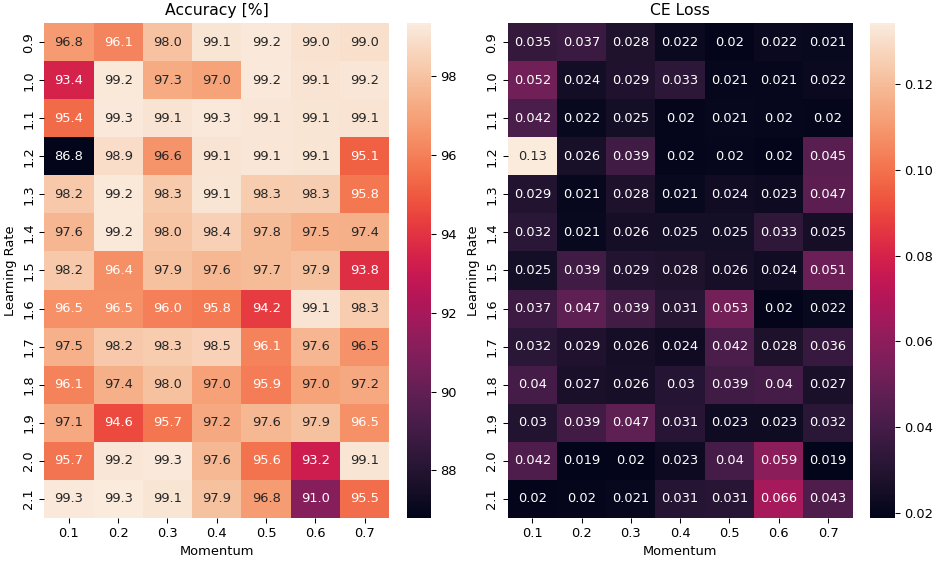

[Text(0.5, 1.0, 'CE Loss')]

In [26]:
#Training data


%matplotlib notebook
fig2, ax2 = plt.subplots(1,2,figsize = (10,6),layout = 'constrained')

sns.heatmap(acc_train_grid,ax=ax2[0],annot = True,fmt= '.1f')
# sns.heatmap(acc_std_train_grid,ax=ax2[0,1],annot = True)

sns.heatmap(loss_train_grid,ax=ax2[1],annot = True)
# sns.heatmap(loss_std_train_grid,ax=ax2[1,1],annot = True)

ax2[0].set(xlabel="Momentum", ylabel="Learning Rate",xticklabels = (momentum_values).numpy(),yticklabels = (learning_rate_values).numpy())
ax2[0].set(title= "Accuracy [%]")

# ax2[0,1].set(xlabel="Momentum", ylabel="Learning Rate",xticklabels = (momentum_values).numpy(),yticklabels = (learning_rate_values).numpy())
# ax2[0,1].set(title= "Accuracy Std dev. [%]")

ax2[1].set(xlabel="Momentum", ylabel="Learning Rate",xticklabels = (momentum_values).numpy(),yticklabels = (learning_rate_values).numpy())
ax2[1].set(title= "CE Loss")

# ax2[1,1].set(xlabel="Momentum", ylabel="Learning Rate",xticklabels = (momentum_values).numpy(),yticklabels = (learning_rate_values).numpy())
# ax2[1,1].set(title= "CE Loss Std dev.")



In [27]:
plt.savefig('model1_CV_train',dpi = 200)

<IPython.core.display.Javascript object>


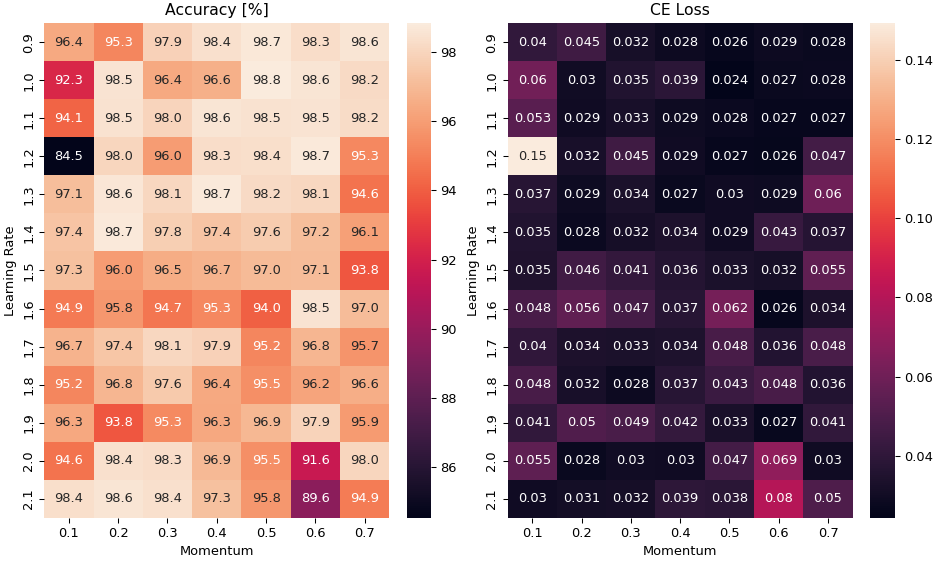

[Text(0.5, 1.0, 'CE Loss')]

In [28]:
%matplotlib notebook
fig3, ax3 = plt.subplots(1,2,figsize = (10,6),layout = 'constrained')

sns.heatmap(acc_test_grid,ax=ax3[0],annot = True,fmt= '.1f')
# sns.heatmap(acc_std_test_grid,ax=ax3[0,1],annot = True)

sns.heatmap(loss_test_grid,ax=ax3[1],annot = True)
# sns.heatmap(loss_std_test_grid,ax=ax3[1,1],annot = True)

ax3[0].set(xlabel="Momentum", ylabel="Learning Rate",xticklabels = (momentum_values).numpy(),yticklabels = (learning_rate_values).numpy())
ax3[0].set(title= "Accuracy [%]")

# ax3[0,1].set(xlabel="Momentum", ylabel="Learning Rate",xticklabels = (momentum_values).numpy(),yticklabels = (learning_rate_values).numpy())
# ax3[0,1].set(title= "Accuracy Std dev. [%]")

ax3[1].set(xlabel="Momentum", ylabel="Learning Rate",xticklabels = (momentum_values).numpy(),yticklabels = (learning_rate_values).numpy())
ax3[1].set(title= "CE Loss")

# ax3[1,1].set(xlabel="Momentum", ylabel="Learning Rate",xticklabels = (momentum_values).numpy(),yticklabels = (learning_rate_values).numpy())
# ax3[1,1].set(title= "CE Loss Std dev.")

In [29]:
plt.savefig('model_CV_test',dpi = 200)

In [40]:
print("learning rate values:",learning_rate_values)
print("Momentum values:", momentum_values)

print("\nTraining")
print("Maximum Accuracy",acc_train_grid.max(), "+-",acc_std_train_grid[acc_train_grid == acc_train_grid.max()])
print("Learning Rate at maximum accuracy:",LR[acc_train_grid == acc_train_grid.max()])
print("Momentum at maximum accuracy:",M[acc_train_grid == acc_train_grid.max()])
print("Loss at maximum accuracy",loss_train_grid[acc_train_grid == acc_train_grid.max()],"+-",loss_std_train_grid[acc_train_grid == acc_train_grid.max()])

print("\n Minimum Loss",loss_train_grid.min(), "+-",loss_std_train_grid[loss_train_grid == loss_train_grid.min()])
print("Learning Rate at minimum loss:",LR[loss_train_grid == loss_train_grid.min()])
print("Momentum at minimum loss:",M[loss_train_grid == loss_train_grid.min()])
print("Accuracy at minimum loss",acc_train_grid[loss_train_grid == loss_train_grid.min()],"+-",acc_std_train_grid[loss_train_grid == loss_train_grid.min()])

learning rate values: tensor([0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000])
Momentum values: tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000])

Training
Maximum Accuracy tensor(99.3373) +- tensor([0.1725])
Learning Rate at maximum accuracy: tensor([2.1000])
Momentum at maximum accuracy: tensor([0.2000])
Loss at maximum accuracy tensor([0.0203]) +- tensor([0.0036])

 Minimum Loss tensor(0.0190) +- tensor([0.0018])
Learning Rate at minimum loss: tensor([2.])
Momentum at minimum loss: tensor([0.7000])
Accuracy at minimum loss tensor([99.0953]) +- tensor([0.3589])


In [42]:
print("\nTesting")
print("Maximum Accuracy",acc_test_grid.max(), "+-",acc_std_test_grid[acc_test_grid == acc_test_grid.max()])
print("Learning Rate at maximum accuracy:",LR[acc_test_grid == acc_test_grid.max()])
print("Momentum at maximum accuracy:",M[acc_test_grid == acc_test_grid.max()])
print("Loss at maximum accuracy",loss_test_grid[acc_test_grid == acc_test_grid.max()],"+-",loss_std_test_grid[acc_test_grid == acc_test_grid.max()])

print("\n Minimum Loss",loss_test_grid.min(), "+-",loss_std_test_grid[loss_test_grid == loss_test_grid.min()])
print("Learning Rate at minimum loss:",LR[loss_test_grid == loss_test_grid.min()])
print("Momentum at minimum loss:",M[loss_test_grid == loss_test_grid.min()])
print("Accuracy at minimum loss",acc_test_grid[loss_test_grid == loss_test_grid.min()],"+-",acc_std_test_grid[loss_test_grid == loss_test_grid.min()])


Testing
Maximum Accuracy tensor(98.8291) +- tensor([1.0579])
Learning Rate at maximum accuracy: tensor([1.])
Momentum at maximum accuracy: tensor([0.5000])
Loss at maximum accuracy tensor([0.0243]) +- tensor([0.0057])

 Minimum Loss tensor(0.0243) +- tensor([0.0057])
Learning Rate at minimum loss: tensor([1.])
Momentum at minimum loss: tensor([0.5000])
Accuracy at minimum loss tensor([98.8291]) +- tensor([1.0579])
